# Exercise 1

(yield curve) Use the results from Exercise 3 last week

    a. Plot the yield curve. Does something look odd? If so, what?
    b. Calculate the Nelson-Siegel coefficients and fitted interest rates
    c. Plot the the Nelson-Siegel fitted yield curve in the same plot as before and
    compare
    
**Note:** You may have to remove some of the bonds from your data before computing the Nelson-Siegel coefficients.


Data collected manually from the website 'http://www.nasdaqomxnordic.com/bonds/denmark' on 2021-09-15


Part a
Cash flow for the bonds:

            1,5St.l.23 GB  3St.l. 21 GB  4,5 St.l 39 GB  7 St.l 24 GB  \
2021-09-15    -105.569315    -103.10863     -181.707945   -130.130137   
2021-11-15       1.500000     103.00000        4.500000      7.000000   
2022-11-15       1.500000       0.00000        4.500000      7.000000   
2023-11-15     101.500000       0.00000        4.500000      7.000000   
2024-11-15       0.000000       0.00000        4.500000    107.000000   
2025-11-15       0.000000       0.00000        4.500000      0.000000   
2026-11-15       0.000000       0.00000        4.500000      0.000000   
2027-11-15       0.000000       0.00000        4.500000      0.000000   
2028-11-15       0.000000       0.00000        4.500000      0.000000   
2029-11-15       0.000000       0.00000        4.500000      0.000000   
2030-11-15       0.000000       0.00000        4.500000     

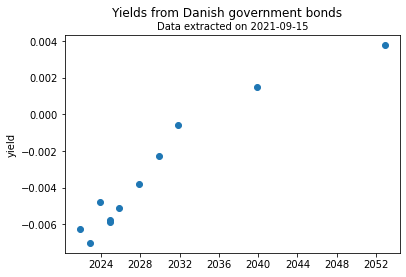

In [10]:
#### FROM EXERCISE SOLUTION ####

import matplotlib.pyplot as plt, pandas as pd, datetime, numpy as np, scipy.optimize as optimize

start_date_str = '2021-09-15'

print("Data collected manually from the website 'http://www.nasdaqomxnordic.com/bonds/denmark' on " +
		start_date_str + '\n')

start_date = datetime.datetime.fromisoformat(start_date_str)
last_coupon_date = datetime.datetime.fromisoformat('2020-11-15')

dict_bonds = {'Bond':['1,5St.l.23 GB', '3St.l. 21 GB', '4,5 St.l 39 GB', '7 St.l 24 GB',
						'DANSKE STAT 2022', 'DANSKE STAT 2029', 
						'Danske Stat 2024', 'Danske Stat 2025', 'Danske Stat 2027',
						'Danske Stat 2031', 'Danske Stat 2052'],
         	 'Price':[104.32,100.61,177.96,124.3,101.12,105.99,
         	 			101.88, 109.56, 105.51, 100.57, 96.23],
         	 'Coupon':[1.50,3.00,4.50,7.00,0.25,0.50,0.00,1.75,0.50,0.00,0.25],
         	 'MatYear':[2023,2021,2039,2024,2022,2029,2024,2025,2027,2031,2052]}

# Part 3a
print('\nPart a')

bonds = pd.DataFrame(dict_bonds)
bonds.set_index('Bond', inplace=True)

bonds['MatDate'] = bonds['MatYear'].apply(lambda x: datetime.datetime(x,11,15))
bonds['DirtyPrice'] = bonds['Price'] + bonds['Coupon']*(start_date-last_coupon_date).days/365

#bonds = bonds.drop("Danske Stat 2024", axis=0)
#bonds = bonds.drop("Danske Stat 2031", axis=0)
#bonds = bonds.dropna(axis=0, how="any")


# Create list of times for the cash flow
times = list(range(start_date.year,max(dict_bonds['MatYear'])+1))
times = [datetime.datetime(x,11,15) for x in times]
times.insert(0,start_date)

# Create the dirty cash flow
CFdirty = pd.DataFrame(0, index=dict_bonds['Bond'], columns=times)
# Insert the dirty price
CFdirty[times[0]] = -bonds['DirtyPrice']
# Insert coupons and PAR
for i in range(1,len(times)):
	CFdirty[times[i]] = bonds['Coupon']*(times[i].year<=bonds['MatYear']) + 100*(times[i].year==bonds['MatYear'])

print('Cash flow for the bonds:\n')
print(CFdirty.transpose())

cashflow_df = CFdirty.transpose()

cashflow_df.to_excel("cashflow_dirty.xlsx")

# Part 3b
print('\nPart b')

# Get time since start
time_since_start = pd.DataFrame(np.NaN, index=times, columns=['t'])
for t in times:
	time_since_start['t'][t] = (t-start_date).days/365

# Calculate the yield to maturity
YtM = pd.DataFrame(np.NaN, index=dict_bonds['Bond'], columns=['T', 'YtM'])
YtM['T'] = bonds['MatDate']

def calculate_absdiff(r):
	value = 0
	for t in times[1:]:
		value += CFdirty[t][bond]*(1+r)**-time_since_start['t'][t]
	return abs(value+CFdirty[times[0]][bond])

for bond in dict_bonds['Bond']:
	YtM.loc[bond, 'YtM'] = optimize.newton(calculate_absdiff, -0.01, tol=1e-10, maxiter=100)

print('Yield to maturity')
print(YtM)


# Part 3c
print('\nPart c')
print('Visualize yields')
# To avoid future warning deregister mpl converters
from pandas.plotting import deregister_matplotlib_converters
deregister_matplotlib_converters()

plt.scatter(YtM['T'], YtM['YtM'])
plt.suptitle('Yields from Danish government bonds')
plt.title('Data extracted on ' + start_date_str, fontsize=10)
plt.ylabel('yield')
plt.show()

### 1a) Plot the yield curve. Does something look odd? If so, what?



The points for "DGBI 2021 GB" and "DGBi" deviate from the yield curve. 

More maturities than bonds, the system is always ill-defined. (Se piazza post)

### 1b) Calculate the Nelson-Siegel coefficients and fitted interest rates

In [11]:
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

maturity = np.array([3,1,19,4,2,9,4,5,7,11,32])
ytm = np.array([-0.004781182876998311, -0.0062875045307910615, 0.0014761457005752698, -0.00578818015530931, 
                -0.007022199046629919, -0.0022569620276429044, -0.0058585659248958765, -0.0051330585335954615, 
                -0.0038109007699065594, -0.0005585816165400206, 0.003781955198807505])
curve, status = calibrate_ns_ols(maturity, ytm, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success

print("Calculated the Nelson-Siegel coefficients and got the following values:")
print(curve)

Calculated the Nelson-Siegel coefficients and got the following values:
NelsonSiegelCurve(beta0=0.004895850049793461, beta1=-0.0077707451307986, beta2=-0.025433143523176212, tau=1.8428043993540426)


In [12]:
# Fitted interest rates
fitted_rates = curve(maturity)
print(fitted_rates)

[-0.00650254 -0.00594759  0.00167637 -0.00575355 -0.00677229 -0.00165892
 -0.00575355 -0.00484346 -0.00307972 -0.00058748  0.00298372]


### C) Nelson-Siegel plot

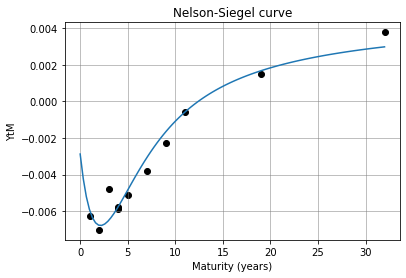

In [13]:
import matplotlib.pyplot as plt
y = curve
t = np.linspace(0, 32, 100)
plt.plot(t, y(t))
plt.scatter(maturity, ytm, color="black")

plt.title('Nelson-Siegel curve')
plt.xlabel('Maturity (years)')
plt.ylabel('YtM')
plt.grid(color='grey', linestyle='-', linewidth=0.5)

# Exercise 2 

(duration, convexity) Use the results from Exercise 3 last week.

    a. Compute the Macaulay duration and the modified duration for all bonds
    b. Compute the convexity for all bonds
    c. Compute Fisher-Weil durations and convexities using the obtained term
    structure model from Question 1

### 2a) Compute the Macaulay duration and the modified duration for all bonds

In [14]:
#Denne metoden fungerer for en enkelt. Må vel bare lage liste for å kjøre gjennom alle bonds. 
def macaulay_duration(c, y, m, n):
    """Parameters:
        c = coupon rate per period
        y = yield per period
        m = periods per year
        n = periods remaining
        
        Example: Consider a 7% bond with 3 years to maturity. 
        Assume bond is selling at 8% yield. 
        
        Then we would c=.035, y=.04, m=2, n=6"""
    macaulay_duration = ((1+y) / (m*y)) - ( (1 + y + n*(c-y)) / ((m*c* ((1+y)**n - 1)) + m*y) )
    return macaulay_duration 

def modified_duration(c, y, m, n):
    modified_duration = macaulay_duration(c, y, m, n) / (1 + y)
    return modified_duration
    

#durations_explicit(c=.035, y=.03, m=2, n=8)

In [15]:
print("Macaulay Durations:")
print("1,5St.l.23 GB:", macaulay_duration(c=0.015, y=0.015, m=1, n=3))
print("3St.l. 21 GB:", macaulay_duration(c=0.03, y=0.03, m=1, n=1))
print("4,5 St.l 39 GB:", macaulay_duration(c=0.045, y=0.045, m=1, n=19))
print("7 St.l 24 GB:", macaulay_duration(c=0.07, y=0.07, m=1, n=4))
print("DANSKE STAT 2022:", macaulay_duration(c=0.0025, y=0.0025, m=1, n=2))
print("DANSKE STAT 2029:", macaulay_duration(c=0.005, y=0.005, m=1, n=9))
#Zero coupon: print("Danske Stat 2024:", macaulay_duration(c=0, y=0, m=1, n=4))
print("DANSKE STAT 2025:", macaulay_duration(c=0.0175, y=0.0175, m=1, n=5))
print("Danske Stat 2027:", macaulay_duration(c=0.005, y=0.005, m=1, n=7))
#Zero coupon: print("Danske Stat 2031:", macaulay_duration(c=0, y=0, m=1, n=5))
print("Danske Stat 2052:", macaulay_duration(c=0.0025, y=0.0025, m=1, n=32))

print("________________________________________________________________________")
print("Modified Durations:")
print("1,5St.l.23 GB:", modified_duration(c=0.015, y=0.015, m=1, n=3))
print("3St.l. 21 GB:", modified_duration(c=0.03, y=0.03, m=1, n=1))
print("4,5 St.l 39 GB:", modified_duration(c=0.045, y=0.045, m=1, n=19))
print("7 St.l 24 GB:", modified_duration(c=0.07, y=0.07, m=1, n=4))
print("DANSKE STAT 2022:", modified_duration(c=0.0025, y=0.0025, m=1, n=2))
print("DANSKE STAT 2029:", modified_duration(c=0.005, y=0.005, m=1, n=9))
#Zero coupon: print("Danske Stat 2024:", modified_duration(c=0, y=0, m=1, n=4))
print("DANSKE STAT 2025:", modified_duration(c=0.0175, y=0.0175, m=1, n=5))
print("Danske Stat 2027:", modified_duration(c=0.005, y=0.005, m=1, n=7))
#Zero coupon: print("Danske Stat 2031:", modified_duration(c=0, y=0, m=1, n=5))
print("Danske Stat 2052:", modified_duration(c=0.0025, y=0.0025, m=1, n=32))


Macaulay Durations:
1,5St.l.23 GB: 2.9558834235239573
3St.l. 21 GB: 1.0
4,5 St.l 39 GB: 13.15999180339871
7 St.l 24 GB: 3.6243160444164015
DANSKE STAT 2022: 1.9975062344138337
DANSKE STAT 2029: 8.82295923969042
DANSKE STAT 2025: 4.8309425395582934
Danske Stat 2027: 6.8963844060683925
Danske Stat 2052: 30.79338786820682
________________________________________________________________________
Modified Durations:
1,5St.l.23 GB: 2.912200417264983
3St.l. 21 GB: 0.970873786407767
4,5 St.l 39 GB: 12.593293591769102
7 St.l 24 GB: 3.3872112564639263
DANSKE STAT 2022: 1.9925249221085624
DANSKE STAT 2029: 8.779063920089971
DANSKE STAT 2025: 4.747855075732966
Danske Stat 2027: 6.8620740358889485
Danske Stat 2052: 30.716596377263663


### 2b) Compute the convexity for all bonds

In [16]:
def convexity(P, y, T, cf):
    sum_over_T = 0
    cf_discounted = [] #Finne nåverdi av utbetalingene i CF
    
    for i in range(1,len(cf)+1):
        cf_discounted.append(cf[i-1]/(1+y)**i)
    
    new_bond_price = sum(cf_discounted) #Finne nåverdi av face value
    
    for t in range(1,T+1): #begynner fra første periode, altså første utbetaling
        sum_over_T += (cf_discounted[t-1]/(1+y)**t)*(t**2+t)
        
    convexity = (1/(new_bond_price*(1+y)**2)) * sum_over_T
    
    return round(convexity,2)
    

In [17]:
#Test with example

#cf = [0.06*1000 for x in range(3)]
#cf.append(1000*1.06)
#print(cf)

#cf_discount = [57.14, 54.42, 51.83, 872.06]
#print("CONVEXITY", round(convexity(1000, 0.05, 4, cf),2))

In [18]:
cashflows = []

cashflows.append([1.5,1.5, 101.5])
cashflows.append([103])
cashflows.append([4.5 for x in range(18)])
cashflows[2].append(104.5)
cashflows.append([7, 7, 7, 107])
cashflows.append([0.25, 100.25])
cashflows.append([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5, 100.5])
cashflows.append([0,0,0, 100])
cashflows.append([1.75, 1.75, 1.75, 1.75, 101.75])
cashflows.append([0.5,0.5,0.5,0.5,0.5,0.5,100.5])
cashflows.append([0,0,0,0,0,0,0,0,0,0,100])
cashflows.append([0.25 for x in range(31)])
cashflows[10].append(100.25)

In [19]:
print("########## CONVEXITY ##########\n")
print("1,5St.l.23 GB:\t\t", convexity(P=104.32, y=0.015, T=3, cf=cashflows[0]))
print("3St.l. 21 GB:\t\t", convexity(P=100.61, y=0.03, T=1, cf=cashflows[1]))
print("4,5 St.l 39 GB:\t\t", convexity(P=177.96, y=0.045,T=19, cf=cashflows[2]))
print("7 St.l 24 GB:\t\t", convexity(P=124.3, y=0.07, T=4, cf=cashflows[3]))
print("DANSKE STAT 2022:\t", convexity(P=101.12, y=0.0025, T=2, cf=cashflows[4]))
print("DANSKE STAT 2029:\t", convexity(P=105.99, y=0.005, T=9, cf=cashflows[5]))
#Zero coupon: 
print("Danske Stat 2024:\t", convexity(P=101.88, y=0, T=4, cf=cashflows[6]))
print("DANSKE STAT 2025:\t", convexity(P=109.56, y=0.0175, T=5, cf=cashflows[7]))
print("Danske Stat 2027:\t", convexity(P=105.51, y=0.005, T=7, cf=cashflows[8]))
#Zero coupon: 
print("Danske Stat 2031:\t", convexity(P=100.57, y=0, T=5, cf=cashflows[9]))
print("Danske Stat 2052:\t", convexity(P=96.23, y=0.0025, T=32, cf=cashflows[10]))



########## CONVEXITY ##########

1,5St.l.23 GB:		 10.92
3St.l. 21 GB:		 1.83
4,5 St.l 39 GB:		 97.91
7 St.l 24 GB:		 11.75
DANSKE STAT 2022:	 5.93
DANSKE STAT 2029:	 82.98
Danske Stat 2024:	 20.0
DANSKE STAT 2025:	 25.39
Danske Stat 2027:	 52.49
Danske Stat 2031:	 0.0
Danske Stat 2052:	 921.95


### 2c) Compute Fisher-Weil durations and convexities using the obtained term structure model from Question 1

In [70]:


def fisher_weil_dur(P, T, cf, r):
    cf_discounted = [] #Finne nåverdi av utbetalingene i CF
    summeledd = 0
    
    for i in range(1,len(cf)+1):
        cf_discounted.append(cf[i-1]/(1+r)**i)
        
    new_bond_price = sum(cf_discounted) #Finne nåverdi av face value
        
    for t in range(1, T+1):
        summeledd += t*cf[t-1]/(1+r)**(t+1)
    
    fisher_weil_dur = 1/new_bond_price * summeledd
    
    return fisher_weil_dur
    

def convexity_adjustment(P, T, cf, r):
    
    cf_discounted = [] #Finne nåverdi av utbetalingene i CF
    summeledd = 0
    
    for i in range(1,len(cf)+1):
        cf_discounted.append(cf[i-1]/(1+r)**i)
        
    new_bond_price = sum(cf_discounted) #Finne nåverdi av face value
        
    for t in range(1,T+1):
        summeledd += t*(t+1)*cf_discounted[t-1]/(1+r)**(t+2)
        
    convex_adj = 1/new_bond_price * summeledd
    
    return round(convex_adj,2)

In [71]:
#fitted_rates


#Consider a 2-year bond with face value of $100, a 
#20% semi-annual coupon, and a yield of 4% semi-annually compounded. The total PV will be:



In [72]:
cash = [5.5, 5.5, 5.5, 5.5, 105.5]
r_ex = [0.042, 0.042, 0.045, 0.047, 0.048]
#print("BOND A duration", fisher_weil(P=100, T=5, cf=cash, r=r_ex))

In [73]:
print("########## FISHER WEIL DURATION ##########\n")


print("1,5St.l.23 GB:\t\t", fisher_weil_dur(P=104.32, r=fitted_rates[0], T=3, cf=cashflows[0]))
print("3St.l. 21 GB:\t\t", fisher_weil_dur(P=100.61, r=fitted_rates[1], T=1, cf=cashflows[1]))
print("4,5 St.l 39 GB:\t\t", fisher_weil_dur(P=177.96, r=fitted_rates[2],T=19, cf=cashflows[2]))
print("7 St.l 24 GB:\t\t", fisher_weil_dur(P=124.3, r=fitted_rates[3], T=4, cf=cashflows[3]))
print("DANSKE STAT 2022:\t", fisher_weil_dur(P=101.12, r=fitted_rates[4], T=2, cf=cashflows[4]))
print("DANSKE STAT 2029:\t", fisher_weil_dur(P=105.99, r=fitted_rates[5], T=9, cf=cashflows[5]))
#Zero coupon: 
print("Danske Stat 2024:\t", fisher_weil_dur(P=101.88, r=fitted_rates[6], T=4, cf=cashflows[6]))
print("DANSKE STAT 2025:\t", fisher_weil_dur(P=109.56, r=fitted_rates[7], T=5, cf=cashflows[7]))
print("Danske Stat 2027:\t", fisher_weil_dur(P=105.51, r=fitted_rates[8], T=7, cf=cashflows[8]))
#Zero coupon: 
print("Danske Stat 2031:\t", fisher_weil_dur(P=100.57, r=fitted_rates[9], T=5, cf=cashflows[9]))
print("Danske Stat 2052:\t", fisher_weil_dur(P=96.23, r=fitted_rates[10], T=32, cf=cashflows[10]))

########## FISHER WEIL DURATION ##########

1,5St.l.23 GB:		 2.9767478032674854
3St.l. 21 GB:		 1.0059831797837693
4,5 St.l 39 GB:		 14.769819101060126
7 St.l 24 GB:		 3.6969206120743334
DANSKE STAT 2022:	 2.0111493329650063
DANSKE STAT 2029:	 8.843986185283484
Danske Stat 2024:	 4.0231473838634315
DANSKE STAT 2025:	 4.86484506525211
Danske Stat 2027:	 6.921180812587813
Danske Stat 2031:	 0.0
Danske Stat 2052:	 30.69015636920727


### Discussion
Fisher-Weil duration is a refinement of Macaulay duration, which takes into account the term structure of interest rates. FW calculates the present values of the relevant cashflows by using zero-coupon yield for each respective maturity.

zero-coupon yield = nelson siegel fitted rates from ex. 1
each bond has the same rate for all its periods. 

In [75]:
print("########## FISHER WEIL CONVEXITY ##########\n")

print("1,5St.l.23 GB:\t\t", convexity_adjustment(P=104.32, r=fitted_rates[0], T=3, cf=cashflows[0]))
print("3St.l. 21 GB:\t\t", convexity_adjustment(P=100.61, r=fitted_rates[1], T=1, cf=cashflows[1]))
print("4,5 St.l 39 GB:\t\t", convexity_adjustment(P=177.96, r=fitted_rates[2],T=19, cf=cashflows[2]))
print("7 St.l 24 GB:\t\t", convexity_adjustment(P=124.3, r=fitted_rates[3], T=4, cf=cashflows[3]))
print("DANSKE STAT 2022:\t", convexity_adjustment(P=101.12, r=fitted_rates[4], T=2, cf=cashflows[4]))
print("DANSKE STAT 2029:\t", convexity_adjustment(P=105.99, r=fitted_rates[5], T=9, cf=cashflows[5]))
#Zero coupon: 
print("Danske Stat 2024:\t", convexity_adjustment(P=101.88, r=fitted_rates[6], T=4, cf=cashflows[6]))
print("DANSKE STAT 2025:\t", convexity_adjustment(P=109.56, r=fitted_rates[7], T=5, cf=cashflows[7]))
print("Danske Stat 2027:\t", convexity_adjustment(P=105.51, r=fitted_rates[8], T=7, cf=cashflows[8]))
#Zero coupon: 
print("Danske Stat 2031:\t", convexity_adjustment(P=100.57, r=fitted_rates[9], T=5, cf=cashflows[9]))
print("Danske Stat 2052:\t", convexity_adjustment(P=96.23, r=fitted_rates[10], T=32, cf=cashflows[10]))

print("\n\n\n")
print("########## REGULAR CONVEXITY WITH NELSON-SIEGEL RATES ##########\n")

print("1,5St.l.23 GB:\t\t", convexity(P=104.32, y=fitted_rates[0], T=3, cf=cashflows[0]))
print("3St.l. 21 GB:\t\t", convexity(P=100.61, y=fitted_rates[1], T=1, cf=cashflows[1]))
print("4,5 St.l 39 GB:\t\t", convexity(P=177.96, y=fitted_rates[2],T=19, cf=cashflows[2]))
print("7 St.l 24 GB:\t\t", convexity(P=124.3, y=fitted_rates[3], T=4, cf=cashflows[3]))
print("DANSKE STAT 2022:\t", convexity(P=101.12, y=fitted_rates[4], T=2, cf=cashflows[4]))
print("DANSKE STAT 2029:\t", convexity(P=105.99, y=fitted_rates[5], T=9, cf=cashflows[5]))
#Zero coupon: 
print("Danske Stat 2024:\t", convexity(P=101.88, y=fitted_rates[6], T=4, cf=cashflows[6]))
print("DANSKE STAT 2025:\t", convexity(P=109.56, y=fitted_rates[7], T=5, cf=cashflows[7]))
print("Danske Stat 2027:\t", convexity(P=105.51, y=fitted_rates[8], T=7, cf=cashflows[8]))
#Zero coupon: 
print("Danske Stat 2031:\t", convexity(P=100.57, y=fitted_rates[9], T=5, cf=cashflows[9]))
print("Danske Stat 2052:\t", convexity(P=96.23, y=fitted_rates[10], T=32, cf=cashflows[10]))

########## FISHER WEIL CONVEXITY ##########

1,5St.l.23 GB:		 12.16
3St.l. 21 GB:		 2.04
4,5 St.l 39 GB:		 259.2
7 St.l 24 GB:		 18.46
DANSKE STAT 2022:	 6.16
DANSKE STAT 2029:	 89.33
Danske Stat 2024:	 20.7
DANSKE STAT 2025:	 29.72
Danske Stat 2027:	 56.47
Danske Stat 2031:	 0.0
Danske Stat 2052:	 906.62




########## REGULAR CONVEXITY WITH NELSON-SIEGEL RATES ##########

1,5St.l.23 GB:		 12.16
3St.l. 21 GB:		 2.04
4,5 St.l 39 GB:		 259.2
7 St.l 24 GB:		 18.46
DANSKE STAT 2022:	 6.16
DANSKE STAT 2029:	 89.33
Danske Stat 2024:	 20.7
DANSKE STAT 2025:	 29.72
Danske Stat 2027:	 56.47
Danske Stat 2031:	 0.0
Danske Stat 2052:	 906.62


# Exercise 3

In this task you play the role of bond portfolio manager. A client would like to invest in Danish Government bonds. He asks you to invest DKK 1.000.000 in a portfolio of bonds and wants you to assess the risk of holding this portfolio.

    a. The portfolio calculations should be done using NASDAQ prices from a September-day on or after 
        September 15th. As there is little data in this project, I would not recommend you to 
        spend time on figuring out how to fetch data from the website automatically. 
        Just write them down in your scripts.
    b. Convert prices from clean to dirty or vice versa depending on your data.
    c. The term structure of interest rates should be done with a Nelson-Siegel term
        structure model fitted to all relevant government bond prices.
    d. Derive an expression for the duration of a portfolio of bonds and argue why you must 
        use the interest rates coming from the fitted term-structure model
        instead of rates obtained by calculating each bond's yield to maturity.
    e. Find a portfolio of three bonds with positive portfolio weights, such that the
        duration of the portfolio is X, where X = 5 + 0. 5 * (the digit sum of your
        student numbers).
    f. Using these weights, calculate the convexity of the portfolio as well as the
        value increase/decrease, if the interest rate curve shifts up by 1% (100bp).

**Note: For some bonds, there might be no recent trades and thereby prices for the day where you wish to do the analysis. In that case, you can for instance use the latest price.**

## 3f) Using these weights, calculate the convexity of the portfolio as well as the value increase/decrease

In [2]:

def portfolio_convexity(weights, P_list, y_list, T_list, cf_list):
    convex = 0
    
    for i in range(len(bonds)):
        convex += weights[i]*convexity(P_list[i], y_list[i], T_list[i], cf_list[i])
        
    return convex


#if the interest rate curve shifts up by 1% (100bp).
def portfolio_convexity_with_shift(weights, P_list, y_list, T_list, cf_list):
    convex = 0
    
    for i in range(len(bonds)):
        convex += weights[i]*convexity(P_list[i], y_list[i]+0.01, T_list[i], cf_list[i])
        
    return convex